In [19]:
from Bio import AlignIO
import os
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution

Экстракция данных из файла с геномами и создание датафрейма

In [2]:
def process_info_files(genomes_csv, lst_info_file):
    """
    Process information files to extract relevant data for further analysis.

    Args:
        genomes_csv (str): Path to the CSV file containing genome information.
        lst_info_file (str): Path to the LSTINFO file containing additional information.

    Returns:
        pandas.DataFrame: Processed DataFrame containing necessary information.
    """
    genome_names = pd.read_csv(genomes_csv, sep='\t', header=None).rename(columns={0:'GCF', 1:'species', 2:'strain'})
    genome_names['strain'] = genome_names['strain'].str[len('strain='):]
    genome_names['strain'] = genome_names['strain'].fillna(0)

    lst_info = pd.read_csv(lst_info_file, sep='\t')
    lst_info['GCF'] = lst_info['orig_name'].str.extract(r'(GCF\_\d{9}\.\d{1})', expand=True)

    data_1 = lst_info[['gembase_name', 'GCF']]
    data_2 = pd.merge(data_1, genome_names, on='GCF')

    return data_2

Создаем датафрейм с последовательностями генов.

In [3]:
def convert_fasta_to_dataframe(file_name):
    """
    Convert a FASTA file to a pandas DataFrame.

    Args:
        file_name (str): Path to the input FASTA file.

    Returns:
        pandas.DataFrame: DataFrame containing gene sequences and related information.
    """
    dic = {}
    cur_scaf = ''
    cur_seq = []

    for line in open(file_name):
        if line.startswith(">") and cur_scaf == '':
            cur_scaf = line.split(' ')[0][1:]
        elif line.startswith(">") and cur_scaf != '':
            dic[cur_scaf] = ''.join(cur_seq)
            cur_scaf = line.split(' ')[0][1:]
            cur_seq = []
        else:
            cur_seq.append(line.rstrip())

    dic[cur_scaf] = ''.join(cur_seq)

    names = dic.keys()
    seqs = dic.values()

    genes_dict = {'name': names, 'gene': seqs}
    genes_df = pd.DataFrame.from_dict(genes_dict)
    genes_df['gembase_name'] = genes_df['name'].str.extract(r'(STRP\.0423\.\d{5})', expand=True)

    return genes_df


Смердживаем два датафрейма с предыдущих шагов

In [ ]:
def process_dataframes(genes_df, data_2):
    """
    Process DataFrames containing gene sequences and additional information.

    Args:
        genes_df (pandas.DataFrame): DataFrame containing gene sequences.
        data_2 (pandas.DataFrame): DataFrame containing additional information.

    Returns:
        pandas.DataFrame: Processed DataFrame with merged data.
    """
    input_table = pd.merge(genes_df, data_2, on='gembase_name')
    input_table = input_table[['name', 'GCF', 'species', 'strain', 'gene']]
    input_table = input_table[~input_table['species'].str.contains(' sp.')]

    return input_table

Поиск мисмэтчей в попарных выравниваниях.

In [4]:
def find_mismatches(output_folder):
    mismatches_data = []

    # Проходим по всем файлам в папке output_folder
    for filename in os.listdir(output_folder):
        if filename.endswith('.fas'):
            aligned_file = os.path.join(output_folder, filename)
            
            # Открываем файл с выравниванием
            alignment = AlignIO.read(aligned_file, 'fasta')
            
            # Получаем длину выравнивания
            alignment_length = alignment.get_alignment_length()

            # Разделяем длину на 20 сегментов
            segment_length = alignment_length // 20

            # Проходим по выравниванию с окном длиной segment_length
            for i in range(0, alignment_length, segment_length):
                # Инициализируем счетчик мисматчей для текущего сегмента
                mismatch_count = 0

                # Проходим по каждой позиции в сегменте и сравниваем символы в выравниваниях
                for j in range(segment_length):
                    # Проверяем, что индексы не выходят за пределы длины выравнивания
                    if i + j < alignment_length:
                        # Получаем символы из каждого выравнивания
                        symbol1 = alignment[0, i + j]
                        symbol2 = alignment[1, i + j]
                        
                        # Если символы не совпадают, увеличиваем счетчик мисматчей
                        if symbol1 != symbol2:
                            mismatch_count += 1
                
                # Вычисляем количество мисмэтчей в текущем сегменте, поделенное на длину сегмента
                mismatch_ratio = mismatch_count / segment_length * 100

                # Добавляем данные о мисматчах для текущего сегмента в список
                mismatches_data.append({'File': filename,
                                        'Segment': i // segment_length + 1,
                                        'Mismatch_Count': mismatch_ratio})
    
    # Создаем DataFrame из списка словарей
    df = pd.DataFrame(mismatches_data)
    
    # Переворачиваем таблицу так, чтобы сегменты были столбцами
    df = df.pivot(index='File', columns='Segment', values='Mismatch_Count')
    
    return df

Создаем отдельную папку с парами генов по каждому условию. 

In [5]:
def create_gene_pairs_folders(condition_rows, selection_condition):
    """
    Create folders and save gene pairs based on specified conditions.

    Args:
        condition_rows (pandas.DataFrame): DataFrame containing gene pairs.
        selection_condition (str): Selection condition for filtering gene pairs.
    """
    # Создаем папку для сохранения пар
    output_folder = f"{selection_condition.replace(' ', '_')}_pairs"
    os.makedirs(output_folder, exist_ok=True)

    # Получаем количество строк в DataFrame
    num_rows = len(condition_rows)

    # Проходим по каждой строке в DataFrame
    for i in range(num_rows):
        for j in range(i + 1, num_rows):
            # Получаем значения из пары
            name1, name2 = condition_rows.iloc[i]['name'], condition_rows.iloc[j]['name']
            gcf1, gcf2 = condition_rows.iloc[i]['GCF'], condition_rows.iloc[j]['GCF']

            # Проверяем, что значения из пары не совпадают и GCF у пары разные
            if name1 != name2 and gcf1 != gcf2:
                # Форматируем текст и создаем имя файла
                row1 = condition_rows.iloc[i]
                row2 = condition_rows.iloc[j]
                
                # Заменяем пробелы на нижнее подчеркивание
                species1 = row1['species'].replace(' ', '_')
                species2 = row2['species'].replace(' ', '_')

                formatted_text = f">{row1['name']}_{row1['GCF']}_{species1}_{row1['strain']}\n{row1['gene']}\n"
                formatted_text += f">{row2['name']}_{row2['GCF']}_{species2}_{row2['strain']}\n{row2['gene']}\n"
                
                # Создаем имя файла
                filename = f"{output_folder}/{row1['name']}-{row2['name']}.fasta"

                # Сохраняем пару в файл
                with open(filename, 'w') as file:
                    file.write(formatted_text)

Создаем новую папку, куда записываем попарные выравнивания.

In [6]:
def align_sequences(input_folder, output_folder):
    """
    Align gene sequences using the PRANK algorithm with codon-based alignment.

    Args:
        input_folder (str): Path to the folder containing input FASTA files.
        output_folder (str): Path to the folder for saving aligned sequences.
    """
    # Проверяем, существует ли уже папка с выравниваниями
    if os.path.exists(output_folder):
        print(f"Folder {output_folder} already exists. Skipping alignment.")
        # Если папка существует, переходим сразу к поиску мисмэтчей
        find_mismatches(output_folder)
        return

    os.makedirs(output_folder, exist_ok=True)
    
    # Определяем количество доступных процессоров
    num_processors = multiprocessing.cpu_count()
    
    # Создаем пул процессов
    pool = multiprocessing.Pool(processes=num_processors)
    
    # Получаем список файлов в папке
    files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.fasta')]
    
    # Запускаем выравнивание для каждого файла в пуле процессов
    for filename in files:
        input_path = filename
        output_path = os.path.join(output_folder, f"aligned_{os.path.basename(filename)}")

        command = f"prank -d={input_path} -o={output_path} -codon"
        os.system(command)
    
    # Завершаем работу пула процессов
    pool.close()
    pool.join()
    
    # После каждого выравнивания вызываем функцию для анализа мисмэтчей
    find_mismatches(output_folder)

Строим графики с мисмэтчами

In [2]:
def mismatch_imaging(file_name:str):
    df = pd.read_csv(file_name)
    df.name = file_name[:-len('_mismatches.csv')]

    condition = f'{df.name}'
    folder_name = f'{condition}_plots'
    os.makedirs(folder_name, exist_ok=True)

    # Найдем максимальное значение на всем диапазоне графиков для установки общего предела оси y
    max_value = df.iloc[:, 1:].max().max()

    for index, row in df.iterrows():
        # Получим название из первого столбца
        title = row.iloc[0]

        # Получим значения точек из остальных столбцов
        values = row.iloc[1:].values

        # Сгенерируем список с номерами точек
        indexes = list(range(1, len(values) + 1))

        # Создаем график
        plt.plot(indexes, values, marker='o')

        # Подписали оси и заголовки графика
        plt.xlabel('Number of windows size=20')
        plt.ylabel('Mismatch Ratio % (Mismatch Count / Segment Length)')
        plt.title(f'{title}')

        # Установим общий предел для оси y
        plt.ylim(0, max_value)
        plt.xticks(range(1, 22))

        filename = f'{folder_name}/{title[len('aligned_'):-len('.fasta')]}.png'
        plt.savefig(filename)

        # Очистим текущую фигуру
        plt.clf()

Функция, запускающая тул

In [ ]:
def detect_phase_variations(genomes_csv, lst_info_file, fasta_file, selection_condition):
    """
    Detect phase variations in gene sequences based on specified conditions.

    Args:
        genomes_csv (str): Path to the CSV file containing genome information.
        lst_info_file (str): Path to the LSTINFO file containing additional information.
        fasta_file (str): Path to the FASTA file containing gene sequences.
        selection_condition (str or list of str): Selection condition(s) for filtering gene pairs.
    """
    data_2 = process_info_files(genomes_csv, lst_info_file)
    genes_df = convert_fasta_to_dataframe(fasta_file)
    input_table = process_dataframes(genes_df, data_2)

    if isinstance(selection_condition, list):
        for condition in selection_condition:
            condition_rows = input_table[input_table['species'].str.contains(condition, na=False)]
            create_gene_pairs_folders(condition_rows, condition)
            input_folder = f"{condition.replace(' ', '_')}_pairs"
            output_folder = f"{condition.replace(' ', '_')}_pairs_aligned"
            align_sequences(input_folder, output_folder)
            mismatches_df = find_mismatches(output_folder)
            mismatches_df.to_csv(f'{condition}_mismatches.csv', index=True)
            mismatch_imaging(f'{condition}_mismatches.csv')
    else:
        condition_rows = input_table[input_table['species'].str.contains(selection_condition, na=False)]
        create_gene_pairs_folders(condition_rows, selection_condition)
        input_folder = f"{selection_condition.replace(' ', '_')}_pairs"
        output_folder = f"{selection_condition.replace(' ', '_')}_pairs_aligned"
        align_sequences(input_folder, output_folder)
        mismatches_df = find_mismatches(output_folder)
        mismatches_df.to_csv(f'{selection_condition}_mismatches.csv', index=True)
        mismatch_imaging(f'{selection_condition}_mismatches.csv')

## Функция, определяющая вариацию

In [20]:
pneumonia = pd.read_csv('Streptococcus_pneumoniae_mismatches.csv').fillna(0)

In [21]:
pneumonia_test = pneumonia.loc[44000:47000, :]
pneumonia_test.reset_index(drop=True, inplace=True)

Поиск глобального максимума

In [22]:
def find_global_maximum(y_values):
    x_int = np.arange(1, len(y_values)+1)

    # Интерполяция функции f(x)
    interp_f = interp1d(x_int, y_values)
    # Интерполяционная функция
    def interpolated_f(x):
        return interp_f(x)
    # Определяем функцию потерь для минимизации
    def loss(x):
        return -interpolated_f(x)

    result = differential_evolution(loss, [(1, len(y_values))])
    return round(result.x.item()), round(-result.fun, 4)

In [23]:
def extremum_singularity(values):
    extremums = []
    for _ in range(25):
        extremums.append(find_global_maximum(values)[0])

    extr_lst = list(set(extremums))
    count = 0
    for j in range(1, len(extr_lst)):
        if extr_lst[j-1] + 1 == extr_lst[j] or extr_lst[j-1] + 2 == extr_lst[j]:
            count += 1
    return count == (len(extr_lst)-1)

Разница между `i` и `i+1` точками

In [24]:
def count_differences(values:list) -> list:
    diff = []
    for i in range(1, len(values)):
        diff.append(round(np.abs(values[i] - values[i-1]), 4))
    return diff

Проверка условия, что наибольшее расстояние лежит рядом с экстремумом

In [25]:
def max_dist_near_extr(diff:list, extr:float) -> bool:
    
    max_diff = np.max(diff)
    max_diff_index = diff.index(max_diff)+2

    closeness = [extr-3, extr+3]
    if closeness[0] < max_diff_index < closeness[1]:
        return True
    return False

In [26]:
def less_threshhold(values:list, threshhold:int, n:int) -> bool:
    count = 0
    for value in values:
        if value < threshhold:
            count += 1 
    return count >= n

In [27]:
def more_threshhold(values:list, threshhold:int, n:int) -> bool:
    count = 0
    for value in values:
        if value > threshhold:
            count += 1 
    return count >= n

Достаем выравнивание по имени, чтобы проверить концы на длинные гэпы

In [28]:
def extract_alignment(dir_name, pair_name):

    sequences = []
    with open(os.path.join(f'{dir_name}', pair_name), mode='r') as file:
        seq = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if seq:
                    sequences.append(seq)
                    seq = ''
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

Проверяем на гэпы

In [29]:
def not_long_gap(values:list, dir_name:str, pair_name:str):
    
    seq_1, seq_2 = extract_alignment(dir_name, pair_name)

    window_size = len(seq_1) // 20 

    def count_end_gaps(seq, values, n):
        seq_gaps = []
        for i, value in enumerate(values):
            if value >= 95:
                seq_gaps.append(seq[n*i:n*(i+1)].count('-'))
        return seq_gaps
    
    seq_1_gaps = count_end_gaps(seq_1, values, window_size)
    seq_2_gaps = count_end_gaps(seq_2, values, window_size)

    if seq_1_gaps > seq_2_gaps:
        freq_gaps = [freq / window_size for freq in seq_1_gaps]
        return False in set(map(lambda x: x >= 0.95, freq_gaps))
    freq_gaps = [freq / window_size for freq in seq_2_gaps]
    return False in set(map(lambda x: x >= 0.95, freq_gaps))

In [30]:
dir_name = 'Streptococcus_pneumoniae_pairs_aligned'
gene_pair_1 = 'aligned_STRP.0423.00242.0001i_01233-STRP.0423.00473.0001i_01051.fasta.best.fas'
gene_pair_2 = 'aligned_STRP.0423.00242.0001i_01233-STRP.0423.00473.0001i_01199.fasta.best.fas'
gene_pair_3 = 'aligned_STRP.0423.00242.0001i_01380-STRP.0423.00473.0001i_01051.fasta.best.fas'
gene_pair_4 = 'aligned_STRP.0423.00242.0001i_01380-STRP.0423.00473.0001i_01199.fasta.best.fas'

Проверка пары генов на соблюдения условий для нахождения паттерна в мисмэтачах

In [32]:
def check_gene_pair(dir_name:str, pair_name:str, values:list):
    indexes = list(range(1, len(values) + 1))

    extremum_idx = find_global_maximum(values)[0]
    extremum = find_global_maximum(values)[1]
    differences = count_differences(values)
    
    if any(value > 95 for value in values):
        return extremum_singularity(values) and max_dist_near_extr(differences, extremum_idx) and \
        less_threshhold(values, 20, 14) and more_threshhold(values, 40, 2) and not_long_gap(values, dir_name, pair_name)
    else:
        return extremum_singularity(values) and max_dist_near_extr(differences, extremum_idx) and \
        less_threshhold(values, 20, 14) and more_threshhold(values, 40, 2)



In [33]:
def draw_plot(df:pd.DataFrame, pair_name:str):
    row = df.query("File == @pair_name").drop('File', axis=1)
    values = list(row.iloc[0, 1:])
    indexes = list(range(1, len(values) + 1))
    plt.plot(indexes, values, marker='o')
    plt.xticks(indexes)
    plt.yticks(range(0, 110, 10));

Проверил функцию `check_gene_pair` на первых 200 выравниваниях. Все работает стабильно

In [ ]:
pneumonia_test = pneumonia.iloc[:200, :]
pneumonia_test['check'] = pneumonia_test.apply(lambda x: check_gene_pair(dir_name, x[0], x[1:]), axis= 1)
pneumonia_test_true = pneumonia_test[pneumonia_test['check'] == True]

функция должна 
1) проверять каждую пару из списка
2) для этой пары искать всевозможные комбинации
3) среди этих комбинаций искать схожие графики по экстремумам и по названиям

Для одного выравнивания (чекаем геномы) достаем всевозможные выравнивания генов внутри этих двух геномов

In [35]:
def extract_all_pairs(gene_pair_name:str, df:pd.DataFrame) -> list:
    first = gene_pair_name[len('aligned_'):len('aligned_')+15]
    second = gene_pair_name[len('aligned_STRP.0423.00004.0001i_01903-'):len('aligned_STRP.0423.00004.0001i_01903-')+15]
    gene_pairs = df.loc[df['File'].str.contains(first)].loc[df['File'].str.contains(second)].File.to_list()
    return gene_pairs

Ищем схожие экстремумы по индексу и по значению

In [60]:
def find_similar_extr(extrs:dict):

    matching_pairs = []
    for name, extr in extrs.items():
        for other_name, other_extr in extrs.items():
            if name != other_name and extr[0] == other_extr[0] and abs(extr[1] - other_extr[1]) <= 1:
                matching_pairs.append((name, other_name))
    
    return matching_pairs
    

In [61]:
def filter_dataframe_by_names(df, gene_pairs_local):
    filtered_df = df[df['File'].isin(gene_pairs_local)]
    return filtered_df

Поиск вариации: 
1) проверка всевозможных выравниваний между генами двух геномов на выполнение условий для выявления паттерна
2) записывает словарь, состоящий из элементов: имя_выравнивания:(индекс_экстремума, значение_экстремума)
3) для каждого элемента в словаре ищет такой же по экстремуму
4) выводит список пар с одинаковыми экстремумами

In [62]:
def find_variation(df:pd.DataFrame, genes_pair_name:str, dir_name:str):
    gene_pairs_local = filter_dataframe_by_names(df, extract_all_pairs(genes_pair_name, df))
    gene_pairs_local['check'] = gene_pairs_local.apply(lambda x: check_gene_pair(dir_name, x[0], x[1:]), axis= 1)
    gene_pairs_local = gene_pairs_local[gene_pairs_local['check'] == True]

    extremums = {}
    for gene_pair in gene_pairs_local.File:
        values = list(df.query("File == @gene_pair").drop('File', axis=1).iloc[0])
        extremums[gene_pair] = find_global_maximum(values)
    
    res = find_similar_extr(extremums)
    n = round( len(res) / 2)
    return res[:n]

In [101]:
def find_variation_in_df(input_df:pd.DataFrame, start_pos:int, stop_pos:int, dir_name:str) -> pd.DataFrame:
    input_df_test = input_df.iloc[start_pos:stop_pos, :]
    input_df_test['check'] = input_df_test.apply(lambda x: check_gene_pair(dir_name, x[0], x[1:]), axis=1)
    input_df_test_true = input_df_test[input_df_test['check'] == True]

    genes_pairs_names = input_df_test_true.File.to_list()
    
    output_df = pd.DataFrame(columns=['genome_A','genome_B', 'gene_1A', 'gene_1B', 'gene_2A', 'gene_2B'])
    for genes_pair in genes_pairs_names:
        phase_variation = find_variation(input_df, genes_pair, dir_name)

        if len(phase_variation) >= 2:
            for pair in phase_variation:
                row_to_append = pd.DataFrame([
                    {
                        'genome_A':pair[0][8:23], 
                        'gene_1A':pair[0][30:35],
                        'gene_1B':pair[0][58:63],
                        'genome_B':pair[0][36:51],
                        'gene_2A':pair[1][30:35],
                        'gene_2B':pair[1][58:63]
                    }
                ])
                output_df = pd.concat([output_df, row_to_append], ignore_index=True)
        new_output_df =  output_df[output_df.index % 4 == 0]
    return new_output_df.drop_duplicates(inplace=False)

In [ ]:
dir_name = 'Streptococcus_pneumoniae_pairs_aligned'
ans_df = find_variation_in_df(pneumonia, 45000, 46000, dir_name)

In [103]:
ans_df.drop_duplicates(inplace=False)

,genome_A,genome_B,gene_1A,gene_1B,gene_2A,gene_2B
0,STRP.0423.00242,STRP.0423.00473,01233,01051,01380,01199
4,STRP.0423.00242,STRP.0423.00297,01233,00855,01380,01001
8,STRP.0423.00242,STRP.0423.00317,01233,01004,01380,01152


In [83]:
extract_all_pairs('aligned_STRP.0423.00242.0001i_01233-STRP.0423.00317.0001i_.fasta.best.fas', pneumonia)

['aligned_STRP.0423.00242.0001i_01233-STRP.0423.00317.0001i_01004.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01233-STRP.0423.00317.0001i_01005.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01233-STRP.0423.00317.0001i_01008.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01233-STRP.0423.00317.0001i_01152.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01377-STRP.0423.00317.0001i_01004.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01377-STRP.0423.00317.0001i_01005.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01377-STRP.0423.00317.0001i_01008.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01377-STRP.0423.00317.0001i_01152.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01379-STRP.0423.00317.0001i_01004.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01379-STRP.0423.00317.0001i_01005.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01379-STRP.0423.00317.0001i_01008.fasta.best.fas',
 'aligned_STRP.0423.00242.0001i_01379-STRP.0423.00317.0001i_01152.fasta.best.fas',
 'al

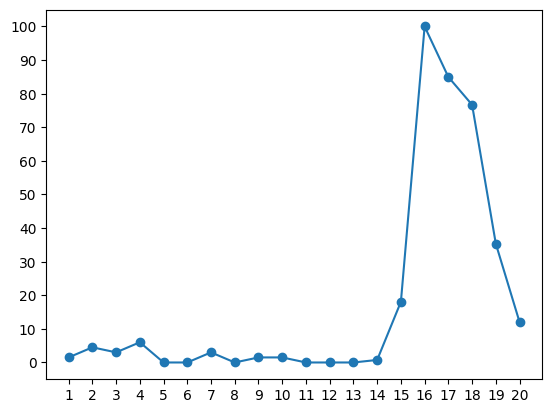

In [87]:
draw_plot(pneumonia, 'aligned_STRP.0423.00242.0001i_01380-STRP.0423.00317.0001i_01152.fasta.best.fas')